In [1]:
%matplotlib inline

In [2]:
from pathlib import Path
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import cv2
import math
from concurrent.futures import ThreadPoolExecutor, as_completed

from aptos.data_loader import ImgProcessor

## PreProcess Images

In [3]:
TRAIN_DIR = Path('../data/raw/diabetic-retinopathy-detection/resized_train_cropped')

In [4]:
train_imgs = list(TRAIN_DIR.glob('*.jpeg'))
print(len(train_imgs))

35108


In [5]:
processor = ImgProcessor()

In [6]:
PROCESS_DIR = Path('../data/preprocessed/diabetic-retinopathy-detection')
PRO_TRAIN_DIR = PROCESS_DIR / 'train_images'
PRO_TRAIN_DIR.mkdir(parents=True, exist_ok=True)

In [7]:
nworkers = 16
with ThreadPoolExecutor(max_workers=nworkers) as executor:
    results = {executor.submit(processor, str(f)): f for f in train_imgs}
    for future in tqdm(as_completed(results), total=len(train_imgs)):
        img = future.result()
        f = results[future]
        save_as = PRO_TRAIN_DIR / f.stem
        np.save(save_as, img)

100%|██████████| 35108/35108 [05:27<00:00, 107.09it/s] 


In [8]:
labels_filename = '../data/raw/diabetic-retinopathy-detection/trainLabels_cropped.csv'
df = pd.read_csv(labels_filename)[['image', 'level']]
df.columns = ['id_code', 'diagnosis']
df.head()

,id_code,diagnosis
0,10_left,0
1,10_right,0
2,13_left,0
3,13_right,0
4,15_left,1


In [9]:
df.to_csv(PROCESS_DIR / 'train.csv', index=False)

## Check train examples

In [10]:
pro_train_imgs = list(PRO_TRAIN_DIR.glob('*.npy'))
print(len(pro_train_imgs))

35108


In [11]:
n_samples = 10
figsize = 8

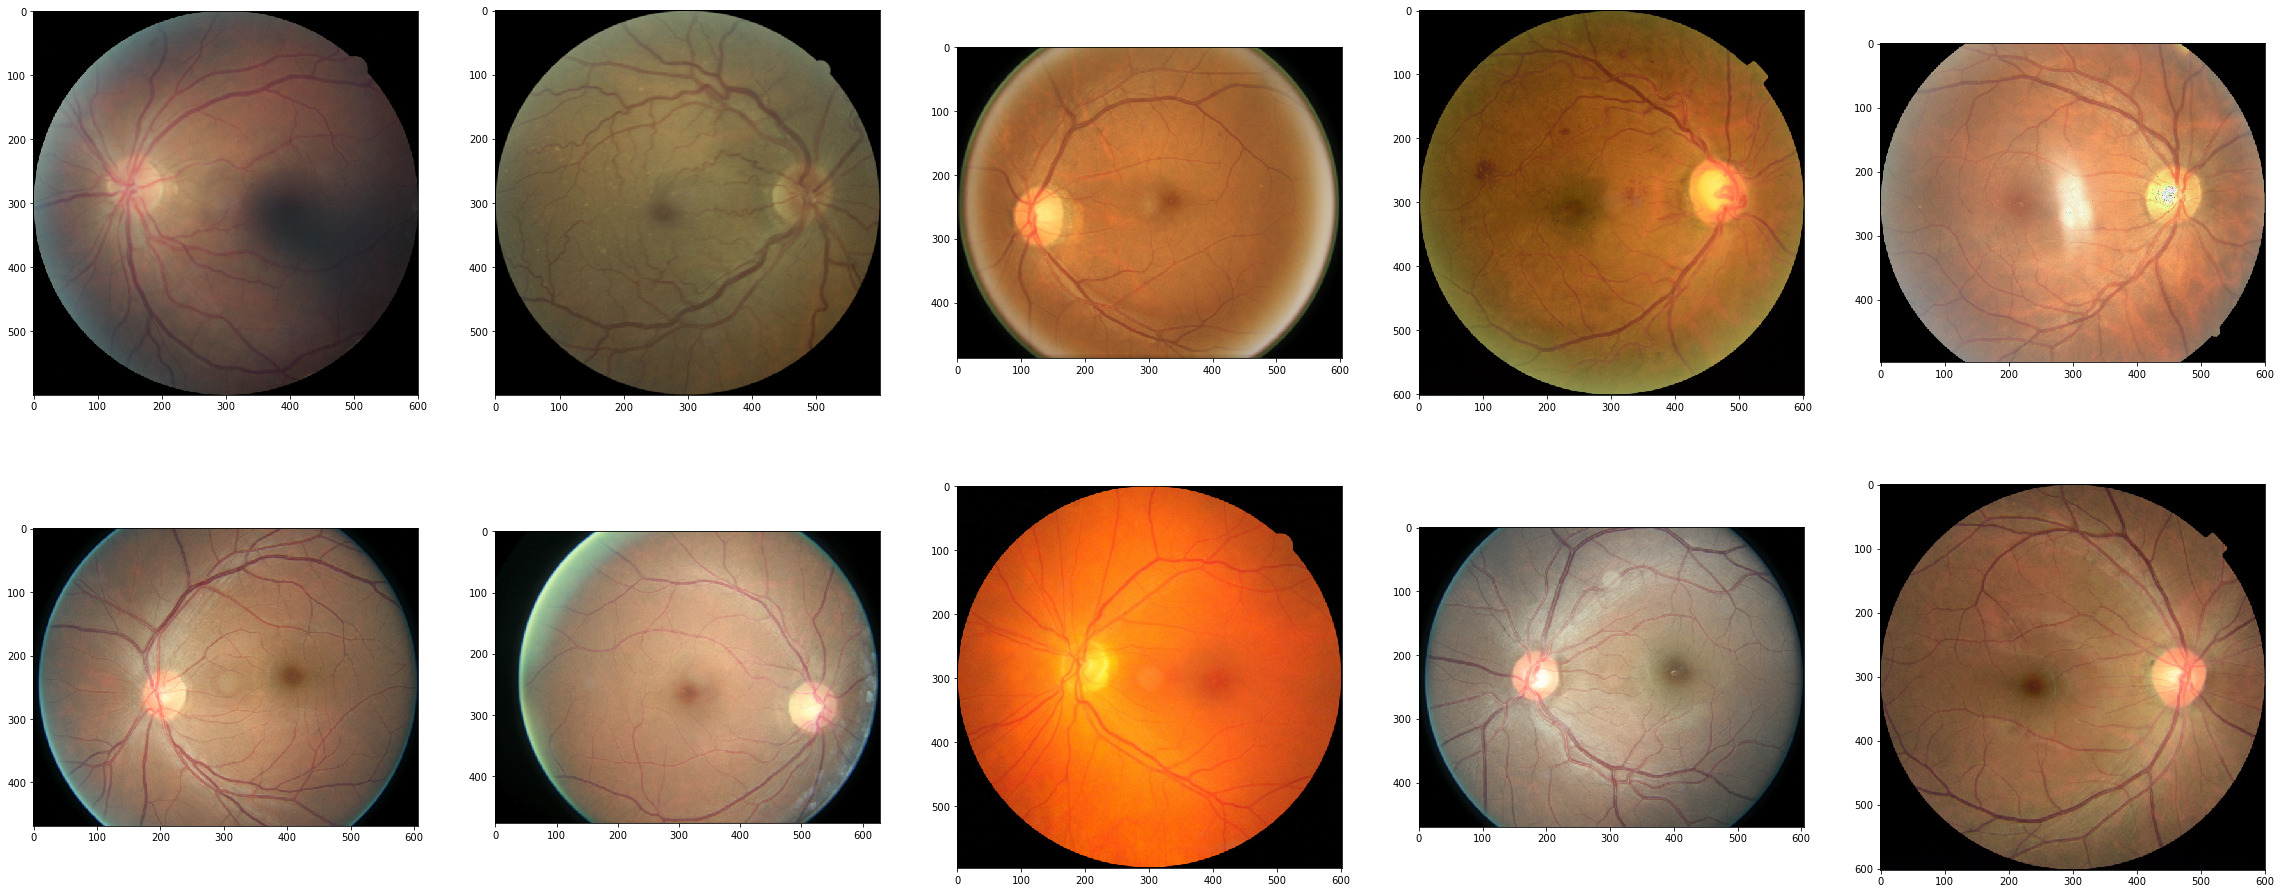

In [12]:
np.random.shuffle(pro_train_imgs)
fig, axs = plt.subplots(2, n_samples // 2, figsize=(40, 16))
for i in range(n_samples // 2):
    train_img = np.load(str(pro_train_imgs[i]))
    axs[0, i].imshow(train_img)
for i in range(n_samples // 2, n_samples):
    train_img = np.load(str(pro_train_imgs[i]))
    axs[1, i - n_samples // 2].imshow(train_img)

## Processed image statistics

In [13]:
print('WARNING: this will consume a LOT (~40GB) of RAM!')
nworkers = 16
means = np.zeros((len(pro_train_imgs), 3))
variances = np.zeros((len(pro_train_imgs), 3))
with ThreadPoolExecutor(max_workers=nworkers) as executor:
    results = {executor.submit(np.load, str(f)): f for f in pro_train_imgs}
    for future in tqdm(as_completed(results), total=len(pro_train_imgs)):
        img = future.result()
        f = results[future]
        idx = pro_train_imgs.index(f)
        means[idx, 0] = img[:, :, 0].mean()
        means[idx, 1] = img[:, :, 1].mean()
        means[idx, 2] = img[:, :, 2].mean()
        variances[idx, 0] = img[:, :, 0].std() ** 2
        variances[idx, 1] = img[:, :, 1].std() ** 2
        variances[idx, 2] = img[:, :, 2].std() ** 2

100%|██████████| 35108/35108 [10:54<00:00, 53.63it/s]


In [17]:
print(means[:, 0].mean() / 255)
print(means[:, 1].mean() / 255)
print(means[:, 2].mean() / 255)

0.425435904540512
0.2968372491300496
0.2123716726086277


In [18]:
print(math.sqrt(variances[:, 0].mean()) / 255)
print(math.sqrt(variances[:, 1].mean()) / 255)
print(math.sqrt(variances[:, 2].mean()) / 255)

0.23488338611200874
0.16641528716966847
0.12489399081128415


In [16]:
# statistics from official competition data
81.68259022825875
87.81281901701134
92.54638140735202

51.061115180201085
54.74800421817656
55.74811655328235

55.74811655328235